## DCL CoCo Bonds

The following code imports data exported from Reuters, then uses it to model DCL CoCo bonds. 

In [12]:
"""
TODO: Add AT1 bond data
TODO: Add CET1 ratio data
TODO: Add shares outstanding data (NS_{k-1})

TODO: Find risk free rates (Yield curve?)
TODO: Derive the following from the data:
    RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m})) # Note that this only applies if the triggers are not breached
    Leverage ratio = Total debt / (Total equity + Total debt) = RQ_k / (RQ_k + NS_{k-1} * S_k)
    alpha = RQ_k / (RQ_k + Book value of non CoCo debt)
"""

'\nTODO: Add AT1 bond data\nTODO: Add CET1 ratio data\nTODO: Add shares outstanding data (NS_{k-1})\n\nTODO: Find risk free rates (Yield curve?)\nTODO: Derive the following from the data:\n    RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m})) # Note that this only applies if the triggers are not breached\n    Leverage ratio = Total debt / (Total equity + Total debt) = RQ_k / (RQ_k + NS_{k-1} * S_k)\n    alpha = RQ_k / (RQ_k + Book value of non CoCo debt)\n'

In [4]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf  # Cufflinks
import configparser as cp

In [6]:
# ================================================================
#                         Model Parameters
# ================================================================

ticker = "CSGN.S"   # Credit Suisse
# ticker = "DBKGn.DE" # Deutsche Bank
# ticker = "LEHMQ.PK" # Lehman Brothers
# ticker = "SVBQ.PK"  # Silicon Valley Bank

T = 10       # Number of years to maturity for DCL bonds
r = 0.05     # Risk free rate
L_min = 0.20 # Minimum leverage ratio
L_c = 0.8    # Critical leverage ratio


In [46]:
# ================================================================
#                     Load data from Reuters
# ================================================================

def add_book_values(stock_data: pd.DataFrame, ticker: str, data_folder = "data/book_values") -> None:
    """
    Add book value of debt to the stock data. 
    """

    # Load the book value data
    # book_value_data = pd.read_excel(f'data/book_values/{ticker}.xlsx', index_col=0, parse_dates=True)
    book_value_data = pd.read_excel(f'{data_folder}/CSGN.xlsx', index_col=0, parse_dates=True)

    # Merge the book value data with the stock data
    stock_data = stock_data.merge(book_value_data, left_index=True, right_index=True, how='left')

    # Fill missing values
    stock_data['Book value of debt'] = stock_data['Book value of debt'].ffill()
    stock_data['Book value of debt'] = stock_data['Book value of debt'].bfill()

    return stock_data

def load_timeseries_data(ticker, data_folder = "data") -> pd.DataFrame: 
    """
    Load timeseries data from a xlsx file. 
    """

    # Read in the data from the Excel file
    dataset = pd.read_excel(f'{data_folder}/cs_timeseries.xlsx', index_col = 0, parse_dates = True)
    dataset = dataset[["CLOSE"]].rename(columns={"CLOSE": "Close"})
    

    return dataset

def load_shares_outstanding(ticker, data_folder = "data"):
    shares_outstanding = pd.read_excel((f'{data_folder}/cs_dcl_data.xlsx'), index_col = 2, parse_dates = True)
    shares_outstanding = shares_outstanding.drop(shares_outstanding.columns[0], axis=1)
    shares_outstanding = shares_outstanding.drop(shares_outstanding.columns[0], axis=1)
    shares_outstanding = shares_outstanding.drop(shares_outstanding.columns[0], axis=1)
    shares_outstanding = shares_outstanding.drop(shares_outstanding.columns[0], axis=1)
    shares_outstanding = shares_outstanding[[shares_outstanding.columns[0]]]
    shares_outstanding.index = shares_outstanding.index.tz_localize(None)

    return shares_outstanding

def load_market_cap(ticker, data_folder = "data"):
    market_cap = pd.read_excel((f'{data_folder}/cs_dcl_data.xlsx'), index_col = 2, parse_dates = True)
    market_cap = market_cap[[market_cap.columns[2]]]
    market_cap.index = market_cap.index.tz_localize(None)


    return market_cap

# input_data = add_book_values(input_data, ticker)

# # Shares outstanding from book value data:
# shares_outstanding = {
#     "2018": 2_550_600_000, 
#     "2019": 2_436_200_000, 
#     "2020": 2_406_144_879, 
#     "2021": 2_569_684_509, 
#     "2022": 3_941_250_081
# }

input_data = load_timeseries_data(ticker)
shares_outstanding = load_shares_outstanding(ticker)
input_data = input_data.merge(shares_outstanding, left_index=True, right_index=True, how='left')
market_cap = load_market_cap(ticker)
input_data = input_data.merge(market_cap, left_index=True, right_index=True, how='left')
# TODO: Reconcile market cap and shares outstanding
# TODO: Load Total debt
# TODO: Load AT1 debt

input_data["Calculated market cap"] = input_data["Close"] * input_data["Common Shares - Outstanding - Total"]
# input_data[["Calculated market cap", "Company Market Cap"]].plot()


# input_data.plot()
input_data

# shares_outstanding.plot()
# shares_outstanding

# market_cap.plot()
# market_cap






,Close,Common Shares - Outstanding - Total,Company Market Cap,Calculated market cap
Date,,,,
2018-01-03,16.630954,2.288180e+09,4.490913e+10,3.805461e+10
2018-01-04,16.877058,2.288180e+09,4.557369e+10,3.861774e+10
2018-01-05,16.697213,2.288180e+09,4.508805e+10,3.820622e+10
2018-01-08,16.824997,2.288180e+09,4.543311e+10,3.849861e+10
2018-01-09,16.867592,2.288180e+09,4.554813e+10,3.859608e+10
...,...,...,...,...
2023-06-06,0.809600,3.941250e+09,3.240147e+09,3.190836e+09
2023-06-07,0.810200,3.941250e+09,3.242548e+09,3.193201e+09
2023-06-08,0.811000,3.941250e+09,3.245750e+09,3.196354e+09


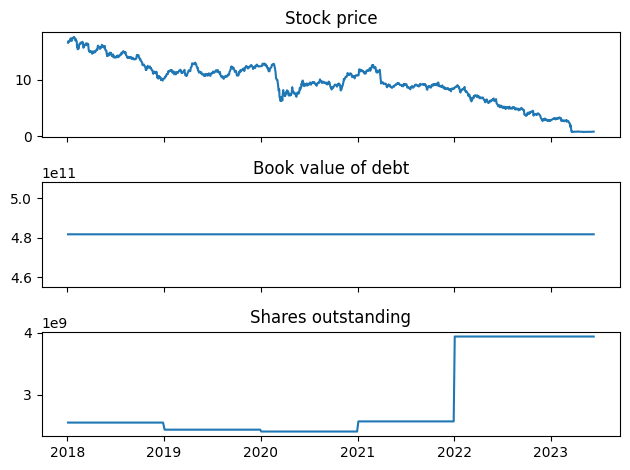

In [16]:
# ================================================================
#                        Plot the data
# ================================================================

def plot_stock_data(stock_data: pd.DataFrame) -> None:
    """
    Plot the stock data. 
    """

    # plot the closing price, the book value of debt in subplots
    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0].plot(stock_data.index, stock_data['Close'], label='Close')
    ax[0].set_title('Stock price')
    ax[1].plot(stock_data.index, stock_data['Book value of debt'], label='Book value of debt')
    ax[1].set_title('Book value of debt')
    ax[2].plot(stock_data.index, stock_data['Shares outstanding'], label='Shares outstanding')
    ax[2].set_title('Shares outstanding')
    plt.tight_layout()
    plt.show()

plot_stock_data(input_data)


In [17]:
# ================================================================
#                    Calculate dependent variables
# ================================================================

def calculate_residual_value_of_dcl(Q, r, N_m, k):
    """
    Calculate the residual value of DCL bond at time k. 
    """

    return Q * ((1 + r)**k + (1 - (1 + r)**k)/(1 - (1 + r)**(-N_m)))

def calculate_alpha(RQ_k, book_value_of_non_coco_debt):
    """
    Calculate the ratio of CoCos to total debt. 
    """
    
    return RQ_k / (RQ_k + book_value_of_non_coco_debt)

def calculate_leverage_ratio(RQ_k, NS_k_1, S_k):
    """
    Calculate the leverage ratio. 
    """

    return RQ_k / (RQ_k + NS_k_1 * S_k)

def simulate_DCL(stock_data, Q_init, r, T, L_min, L_c):
    """
    Simulate the DCL model. 
    """

    stock_data['k'] = stock_data.index.year - stock_data.index.year[0]
    stock_data['Q'] = Q_init

    for day in stock_data.index[0:]:

        stock_data.loc[day, 'RQ_k'] = calculate_residual_value_of_dcl(stock_data.loc[day, 'Q'], r, T, stock_data.loc[day, 'k'])
        stock_data.loc[day, 'Alpha'] = calculate_alpha(stock_data.loc[day, 'RQ_k'], stock_data.loc[day, 'Book value of debt'])
        stock_data.loc[day, 'Leverage ratio'] = calculate_leverage_ratio(stock_data.loc[day, 'RQ_k'], stock_data.loc[day, 'Shares outstanding'], stock_data.loc[day, 'Close'])

        if stock_data.loc[day, 'Leverage ratio'] < L_min:
            print(f"Day {day} - Leverage ratio is below minimum: {stock_data.loc[day, 'Leverage ratio']}")
            stock_data.loc[day, 'Q'] = stock_data.loc[stock_data.index[0], 'Q'] * (1 + stock_data.loc[day, 'Close'] / stock_data.loc[stock_data.index[0], 'Close'])
        elif stock_data.loc[day, 'Leverage ratio'] > L_c:
            print(f"Day {day} - Leverage ratio is above critical: {stock_data.loc[day, 'Leverage ratio']}")
            stock_data.loc[day, 'Q'] = stock_data.loc[day, 'Q'] * (1 + stock_data.loc[day, 'Close'] / stock_data.loc[stock_data.index[0], 'Close'])

    return stock_data

df_dcl_1 = simulate_DCL(input_data, 15_000_000_000, r, T, L_min, L_c)




# stock_data['N_m'] = T
# stock_data['NS_k_1'] = 3_039_000_000
# stock_data['RQ_k'] = stock_data.apply(lambda row: calculate_residual_value_of_dcl(row['Q'], r, row['N_m'], row['k']), axis=1)
# stock_data['Alpha'] = stock_data.apply(lambda row: calculate_alpha(row['RQ_k'], row['Book value of debt']), axis=1)
# stock_data['Leverage ratio'] = stock_data.apply(lambda row: calculate_leverage_ratio(row['RQ_k'], row['NS_k_1'], row['Close']), axis=1)

df_dcl_1


,Close,Book value of debt,Shares outstanding,k,Q,RQ_k,Alpha,Leverage ratio
Exchange Date,,,,,,,,
2018-01-03,16.630954,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.261238
2018-01-04,16.877058,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.258413
2018-01-05,16.697213,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.260471
2018-01-08,16.824997,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.259005
2018-01-09,16.867592,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.258520
...,...,...,...,...,...,...,...,...
2023-06-06,0.809600,481663000000,3.941250e+09,5,15000000000,8.410306e+09,0.017161,0.724955
2023-06-07,0.810200,481663000000,3.941250e+09,5,15000000000,8.410306e+09,0.017161,0.724807
2023-06-08,0.811000,481663000000,3.941250e+09,5,15000000000,8.410306e+09,0.017161,0.724610


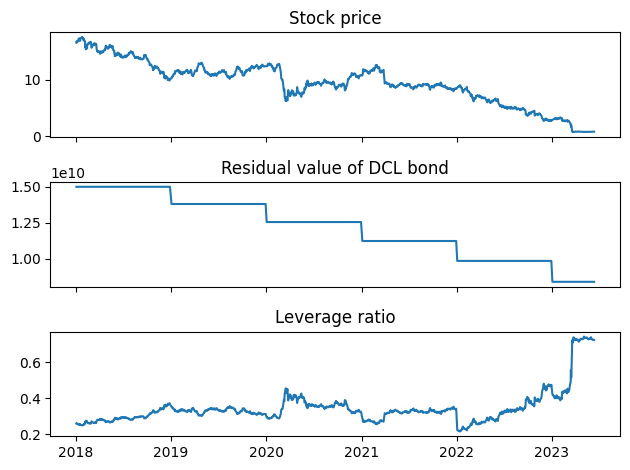

In [18]:
# ================================================================
#                        Plot the results
# ================================================================

def plot_results(df: pd.DataFrame) -> None:
    """
    Plot the results. 
    """

    # plot the closing price, the book value of debt in subplots
    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0].plot(df.index, df['Close'], label='Close')
    ax[0].set_title('Stock price')
    ax[1].plot(df.index, df['RQ_k'], label='RQ_k')
    ax[1].set_title('Residual value of DCL bond')
    ax[2].plot(df.index, df['Leverage ratio'], label='Leverage ratio')
    ax[2].set_title('Leverage ratio')
    plt.tight_layout()
    plt.show()

plot_results(df_dcl_1)
